## Import the necessary packages

In [249]:
import torch
import torchvision

from torch.autograd import Variable
import torch.optim as optim

## Hyperparameters

In [250]:
# Hyperparameters
batch_size = 4
learning_rate = 0.001
num_workers = 4
load_pretrained_model = False
epochs = 50
pretrained_epoch = 15

# CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

## Preparing the training set and testing set

In [251]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Preparing the training set and testing set
transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR100 
trainset = CIFAR100(root='./data', train=True, download=True, transform=transform)
trainset_loader = DataLoader(trainset, batch_size=batch_size, 
                                    shuffle=True, num_workers=num_workers)

testset = CIFAR100(root='./data', train=False, download=True, transform=transform)
testset_loader = DataLoader(testset, batch_size=batch_size,
                                    shuffle=False, num_workers=num_workers)

classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm')

Files already downloaded and verified
Files already downloaded and verified


Test the trainset and testset

In [252]:
# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()
print(images.size())


torch.Size([4, 3, 32, 32])


Let us show some of the training images, for fun.

torch.Size([4, 3, 32, 32])


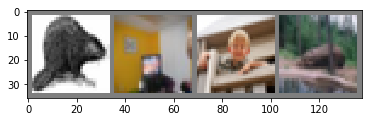

 beaver	television	  boy	elephant


In [253]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))



# print labels
print(' '+'\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Saving and Loading Models Functions

In [254]:
def save_model(net, epoch):
    PATH = "./pretrained_models/model_epoch" + str(epoch+1) + ".pth"
    torch.save(net.state_dict(),PATH)

def load_model(net, pretrained_epoch):
    PATH = "./pretrained_models/model_epoch" + str(pretrained_epoch) + ".pth"
    net.load_state_dict(torch.load(PATH))
    net.eval()

## Test Accuracy function

In [255]:
# define the test accuracy function
def test_accuracy(net, testset_loader, epoch):
    # Test the model
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testset_loader:
            images, labels = data
            images, labels = Variable(images).cuda(), labels.cuda()
            output = net(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print('Accuracy Test -- Epoch '+str(epoch+1)+': ' + str(100 * correct / total))


## Learning Schedule

In [256]:
def l_rate(base_rate, epoch,schedule = False):
    if schedule == False:
        return base_rate
    else:
        if epoch < 10:
            return(base_rate)
        elif epoch >= 10 and epoch < 15:
            return(base_rate/10)
        elif epoch >= 15 and epoch < 25:
            return(base_rate/20)
        else:
            return(base_rate/50)

## Define BasicBlock

In [257]:
import math
import torch.nn as nn
import torch.nn.functional as F
import copy

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding, repeat = 1):
        super(BasicBlock, self).__init__()
        
        self.conv_init = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=padding, bias=True)
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=padding, bias=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.convShortcut_init = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride,
                                      padding=0, bias=True)
        self.convShortcut = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1,
                                      padding=0, bias=True)
        
        self.repeat = repeat
        self.equalInOut = (in_channels == out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
    def forward(self, x):

        out = x.clone()
        y = x.clone()
#         print('_0:', out.size())
        out = self.conv_init(out)
#         print('_1:', out.size())
        out = F.relu(self.bn(out))
#         print('_2:', out.size())
        out = self.bn(self.conv(out))
#         print('_3:', out.size())
        if self.equalInOut:
            out = torch.add(out, x)
        else:
            self.convShortcut.in_channels = y.size()[1]
            out = torch.add(self.convShortcut_init(y), out)
#         print('_4:', out.size())
        out = F.relu(out)     
        
        for i in range(1, self.repeat):
            y = out.clone()
#             print('_0:', out.size())
            out = self.conv(out)
            i += 1
#             print('_1:', out.size())
            out = F.relu(self.bn(out))
#             print('_2:', out.size())
            out = self.bn(self.conv(out))
#             print('_3:', out.size())
#             print('equalInOut', self.equalInOut)
#             print(y.size())
#             print(out.size())
#             print(self.convShortcut.in_channels)
            self.convShortcut.in_channels = y.size()[1]
#             print(self.convShortcut.in_channels)
#             print('hi.1 ---',self.convShortcut(y).size())
#             print('hi.2 ---',out.size())
            out = torch.add(self.convShortcut(y), out)
#             print('_4:', out.size())
            out = F.relu(out)
#             print('_5:', out.size())
        return out


## Define the ResNet class

In [258]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        nChannels = [32 ,32, 64, 128, 256]
        nStride = [1,2,2,2]
        nRepeat = [2,4,4,2]
        
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=True)
        # batch normal layer
        self.bn = nn.BatchNorm2d(nChannels[0])
        
        # dropout layer
        self.Dropout = nn.Dropout(0.25)

        # 1st block
        self.block1 = BasicBlock(in_channels = nChannels[0], out_channels = nChannels[1], 
                                 stride = 1, padding = 1, repeat = nRepeat[0])
        # 2nd block
        self.block2 = BasicBlock(in_channels = nChannels[1], out_channels = nChannels[2], 
                                 stride = 2, padding = 1, repeat = nRepeat[1])
        # 3rd block
        self.block3 = BasicBlock(in_channels = nChannels[2], out_channels = nChannels[3], 
                                 stride = 2, padding = 1, repeat = nRepeat[2])
        # 4th block
        self.block4 = BasicBlock(in_channels = nChannels[3], out_channels = nChannels[4], 
                                 stride = 2, padding = 1, repeat = nRepeat[3])
        # maxpooling layer
        self.pool = nn.MaxPool2d(4,4)
        
        # classifier
        self.fc = nn.Linear(in_features=nChannels[4], out_features=100)
        self.nChannels = nChannels[-1]

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
#         print('1:', out.size())
        out = F.relu(self.bn(out))
#         print('2:', out.size())
        out = self.Dropout(out)
#         print('3:', out.size())
        out = self.block1(out)
#         print('4:', out.size())
        out = self.block2(out)
#         print('5:', out.size())
        out = self.block3(out)
#         print('6:', out.size())
        out = self.block4(out)
#         print('7:', out.size())
        out = self.pool(out)
#         print(out.size())
        out = out.view(-1, self.nChannels)
#         print(out.size())
        out = self.fc(out)
        return out

## Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [259]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(),lr=0.001)

## Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [260]:
resnet = ResNet()
start_epoch = 0
if load_pretrained_model == True:
    load_model(resnet, pretrained_epoch)
    start_epoch = pretrained_epoch

resnet.cuda()

for epoch in range(start_epoch,epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    tmp_loss
    for i, data in enumerate(trainset_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = Variable(inputs).cuda(),Variable(labels).cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        tmp_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, tmp_loss / 2000))
            tmp_loss = 0.0
    # print the loss after every epoch
    print('Epoch ' + str(epoch + 1) + ': loss = ' + str(running_loss / 50000))    
    if (epoch + 1)%5 == 0:
        # Test for accuracy after every 5 epochs
        test_accuracy(net, testset_loader, epoch)
        # Save model after every 5 epochs
        save_model(net, epoch)
    elif epoch == epochs - 1:
        test_accuracy(net, testset_loader, epoch)
        save_model(net, epoch)

print('Finished Training')

AssertionError: Torch not compiled with CUDA enabled